# Homework: Titanic survival dataset exploration

Your goal is to fill #TODO places with your code and answer questions  

Here are some features that can help you determine who survived in Titanic.  
Our quality metric - area under the roc curve

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing
import re
%matplotlib inline

SEED = 1337
# !!you should use that seed in all models which accepts random_state

In [202]:
df = pd.read_csv('./train.csv', index_col=0)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## fill missing values

In [203]:
# TODO 1:
# encode Sex column
# hint: use LabelEncoder

#sex features are categorial so we want to make them numeral
le = preprocessing.LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])

In [204]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S


In [205]:
# print columns with number of missing values for each 
for name in df.columns:
    print(name, np.sum(pd.isnull(df[name])))

Survived 0
Pclass 0
Name 0
Sex 0
Age 177
SibSp 0
Parch 0
Ticket 0
Fare 0
Cabin 687
Embarked 2


In [206]:
# Replace missing values with "unkown"
df.loc[df.Cabin.isnull(), 'Cabin'] = 'unknown'

# fill Fare with median value
#Is it really necessary? There is no NaN in Fare column
df.loc[np.isnan(df['Fare']), 'Fare'] = df['Fare'].median()

# TODO 2
# Replace missing values in Embarked column with most common port
# hint: use Series.mode method

df.loc[df.Embarked.isnull(), 'Embarked'] = df['Embarked'].mode()[0]

In [207]:
#check
print('Embarked', np.sum(pd.isnull(df['Embarked'])))

Embarked 0


In [208]:
# TODO 3
# train Random Forest regression model to fill missing values in Age column
# use  100 estimators, set oob_score in True, other params by default
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

#without Ticket and Cabin
age_columns = ['Age', 'Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 
       'Fare', 'Embarked']

age_df = df[age_columns]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    age_df['Embarked'] = preprocessing.LabelEncoder().fit_transform(age_df['Embarked'])
    train_df = age_df.loc[age_df.Age.notnull()]
    test_df = age_df.loc[age_df.Age.isnull()]
    print('train age', train_df.shape[0])
    print('test age', test_df.shape[0])

train age 714
test age 177


In [209]:
#oob_score counts score as in train data wouldn't be a train one
model = RandomForestRegressor(n_estimators=100, oob_score=True)
model.fit(train_df.loc[:, train_df.columns != 'Age'], train_df['Age'])
df.loc[df.Age.isnull(), 'Age'] = model.predict(test_df.loc[:, test_df.columns != 'Age'])

In [210]:
#check
print('Age', np.sum(pd.isnull(df['Age'])))

Age 0


### Question 1: what is the oob_score of trained model?

In [289]:
model.oob_score_

0.2234075925806005

## feature transformation

In [211]:
# TODO 4
# Create a dataframe of dummy variables for each distinct value of Embarked
# hint: use DataFrame.get_dummies method

# Rename the columns from 'S', 'C', 'Q' to 'Embarked_S', 'Embarked_C', 'Embarked_Q'
# hint: use pandas.rename method

# Add the new dummy variables back to the original data set
# hint: use pandas.concat method

df = pd.concat([df, pd.get_dummies(df['Embarked'])], axis=1)
df.rename({'S':'Embarked_S', 'C':'Embarked_C', 'Q':'Embarked_Q'}, axis='columns')

df['Embarked'] = preprocessing.LabelEncoder().fit_transform(df['Embarked'])

In [212]:
# TODO 5

# create feature for the alphabetical part of the cabin number
# hint: use re module - we can just take the first symbol
 
# convert the distinct cabin letters with incremental integer values
# hint: use pandas.factorize method

df['CabinLetter'] = pd.Series([i[0] for i in list(df.loc[:, 'Cabin'])])
df['CabinLetter'] = df['CabinLetter'].factorize()[0]
df['Cabin'] = preprocessing.LabelEncoder().fit_transform(df['Cabin'])

In [213]:
df['CabinLetter'].head()

PassengerId
1    0
2    1
3    0
4    1
5    1
Name: CabinLetter, dtype: int64

In [214]:
# TODO 6

# Divide all fares into quartiles
# hint: use pandas.qcut

# create dummies from the result and add tham to dataset

df['Fare'] = pd.qcut(df['Fare'], 4, labels=False)
df = pd.concat([df, pd.get_dummies(df['Fare'])], axis=1)
df.rename({0:'Fare_Q0', 1:'Fare_Q1', 2:'Fare_Q2', 3:'Fare_Q3'}, axis='columns')

#df = df.drop('Fare_bin', axis=1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,C,Q,S,CabinLetter,Fare_Q0,Fare_Q1,Fare_Q2,Fare_Q3
PassengerId,,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,0,147,2,0,0,1,0,1,0,0,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,1,0,PC 17599,3,81,0,1,0,0,1,0,0,0,1
3,1,3,"Heikkinen, Miss. Laina",0,26.000000,0,0,STON/O2. 3101282,1,147,2,0,0,1,0,0,1,0,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,1,0,113803,3,55,2,0,0,1,1,0,0,0,1
5,0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,1,147,2,0,0,1,1,0,1,0,0
6,0,3,"Moran, Mr. James",1,31.475631,0,0,330877,1,147,1,0,1,0,2,0,1,0,0
7,0,1,"McCarthy, Mr. Timothy J",1,54.000000,0,0,17463,3,129,2,0,0,1,1,0,0,0,1
8,0,3,"Palsson, Master. Gosta Leonard",1,2.000000,3,1,349909,2,147,2,0,0,1,1,0,0,1,0
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.000000,0,2,347742,1,147,2,0,0,1,1,0,1,0,0


In [215]:
df = df.drop(['Name', 'Ticket'], axis=1)
df.shape

(891, 17)

In [245]:
# TODO 7
# make dimension reduction with PCA, leave enough components to explain 98% variance of the data, 
# other params by default. Project dataset on these components
# Of course, you should not project your target variable
from sklearn import decomposition
from sklearn import preprocessing

X = preprocessing.normalize(preprocessing.scale(df.drop('Survived', True)))
for i in range(len(X[0]), 0):
    pca = decomposition.PCA(n_components=i)
    X_pca = pca.fit_transform(X)
    if .98 <= np.sum(pca.explained_variance_ratio_) < 1.0:
        break

In [246]:
np.sum(pca.explained_variance_ratio_)

0.98326506294811311

### Question 2: how many components are in PCA?

In [251]:
len(pca.components_) #number of components in pca

11

In [278]:
X = df.drop('Survived', axis=1)
y = df.Survived.values
features_list = X.columns
X = X.as_matrix()

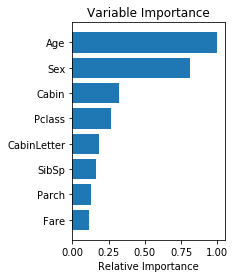

In [279]:
# TODO 8
# plot feature importances from Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
 
# Train Random Forest Classifier on datasert with 5000 trees, other params by default
# get feature importances from model

forest = RandomForestClassifier(n_estimators=5000,
                              random_state=SEED)
forest.fit(X, y)
feature_importance = forest.feature_importances_

# make importances relative to max importance
feature_importance = feature_importance / feature_importance.max()

# A threshold below which to drop features from the final data set. Specifically, this number represents
# the percentage of the most important feature's importance value
fi_threshold = 0.10
 
# Get the indexes of all features over the importance threshold
important_idx = np.where(feature_importance > fi_threshold)[0] #returns indexes of elements under condition
 
# Create a list of all the feature names above the importance threshold
important_features = features_list[important_idx]
 
# Get the sorted indexes of important features
sorted_idx = np.argsort(feature_importance[important_idx])[::-1]
 
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[important_idx][sorted_idx[::-1]], align='center')
plt.yticks(pos, important_features[sorted_idx[::-1]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.draw()
plt.show()

In [285]:
#Remove non-important features from the feature set
X = df[important_features]
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,CabinLetter
PassengerId,,,,,,,,
1,3,1,22.0,1,0,0,147,0
2,1,0,38.0,1,0,3,81,1
3,3,0,26.0,0,0,1,147,0
4,1,0,35.0,1,0,3,55,1
5,3,1,35.0,0,0,1,147,1


### Question 3: What are 4 top most important features?##

####### Age, Sex, Cabin, Pclass

In [286]:
# stack features from pca and the most important from X
X = np.hstack([X, X_pca])
X.shape

(891, 19)

In [314]:
# TODO 9 
# plot learning curves for Random Forest Model (for train and test)
# hint: look at sklearn.learning_curve module. Look at the docs
# use Random Forest with 500 trees, 10-fold cross-validation for roc_auc scoring.

from sklearn.learning_curve import learning_curve
from sklearn.model_selection import KFold

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

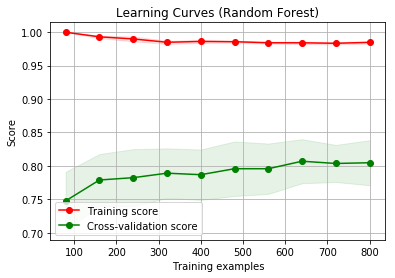

In [317]:
model = RandomForestClassifier(n_estimators=500)
title = "Learning Curves (Random Forest)"
plot_learning_curve(model, title, X, y, cv=10)
plt.show()

In [333]:
# TODO 10
# plot roc auc curve for Random Forest for test dataset
# hint: use roc_curve and auc functions from sklearn.metrics
# use Random Forest with 5000 trees

from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)
model = RandomForestClassifier(n_estimators=5000)
title = "Roc Auc curve (Random Forest)"
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict)
roc_auc = auc(fpr, tpr)

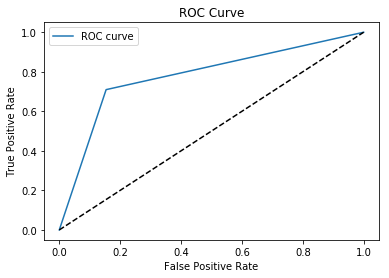

In [334]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.show()

### Question 4: What is the roc auc score on test dataset ? 

In [335]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_predict)

0.77791563275434239

If we use RandomForestRegression it suddenly appears that roc auc score is higher than for RandomForestClassifier.

In [336]:
# TODO 10
# plot roc auc curve for Random Forest for test dataset
# hint: use roc_curve and auc functions from sklearn.metrics
# use Random Forest with 5000 trees

from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)
model = RandomForestRegressor(n_estimators=5000)
title = "Roc Auc curve (Random Forest)"
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict)
roc_auc = auc(fpr, tpr)

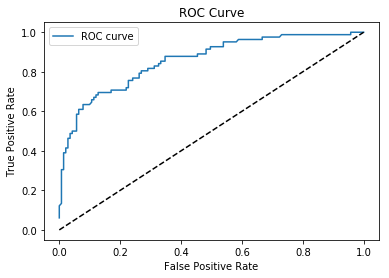

In [337]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.show()

### Question 4: What is the roc auc score on test dataset ? 

In [338]:
roc_auc_score(y_test, y_predict)

0.85711814564954159